In [1]:
# Final version of the water-filling in 1dspace-time.
# slide ratio and get the best reconstruction error fro each ratio between two type

In [179]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [180]:
# parameters


NFREQ = 100 # discretization
f1 = 1e-6 # lowest freq
f2 = 1e0 # highest freq


## equilibrated trapezoid
N = 1 # noise level



In [181]:
# Generate spectrum

X = np.exp(np.linspace(np.log(f1),np.log(f2),NFREQ))
T = np.exp(np.linspace(np.log(f1),np.log(f2),NFREQ))

GX,GT = np.meshgrid(X[:-1],T[:-1])

# Power density
Sdensity = 1/(GX**2*GT**2)
S = np.diff(-1/X)[:,np.newaxis]*np.diff(-1/T)[:,np.newaxis].T

print(S.shape)

# Total Power
total_S = np.sum(S)

print(total_S)

(99, 99)
999998000001.0


In [182]:
## Compute water filling for a range of lambdas

# range of lambdas
NLAMBDAS = 150
#lambdas = np.logspace(12,25,NLAMBDAS)
lambdas = np.logspace(6,25,NLAMBDAS)

# library of water-filling solutions for different lamdas
Ws = list()
for lambd in lambdas:
    F = np.sqrt(N/(lambd*Sdensity)) - N/Sdensity #Filter Magnitue Square per mode
    W = S*F #Total water per block
    W[W<0] = 0 
    
    #plt.figure()
    #plt.imshow(np.sqrt(W), cmap = 'seismic', vmin = -np.max(np.sqrt(W)), vmax =  np.max(np.sqrt(W)),origin='lower')
    #plt.colorbar()
    
    Ws.append(W.T)

Ws = np.array(Ws).T
Ws.shape


(99, 99, 150)

In [183]:
# Sum across temporal frequencies (we don't need those)

# volume of each voxel
Nf = np.diff(X)[:,np.newaxis]*np.diff(T)[:,np.newaxis].T

# Precompute variance per mode explained for all lambdas
colVarExpl = np.sum(S[:,:,np.newaxis]*Ws/(Ws+N*Nf[:,:,np.newaxis]),axis =0)
# cumulative variance explained (it's going to fasten up things in the grid search)
cumVarExpl = np.vstack((np.zeros(NLAMBDAS),np.cumsum(colVarExpl,axis = 0)))

# Water filling array for all modes and lamdas
colWs = np.sum(Ws,axis = 0)
# Cumulative Water filling array (it's going to fasten up things in the grid search)
cumWs = np.vstack((np.zeros(NLAMBDAS),np.cumsum(colWs,axis = 0)))

print(colVarExpl.shape, cumVarExpl.shape,colWs.shape, cumWs.shape)

(99, 150) (100, 150) (99, 150) (100, 150)


In [257]:
## Iterate over all possible decompositions between N cell types to find the best one



# Number of types
NTYPES = 2

## Create grid for grid search

# Create grid for grid search over strides for different types
STEP = 1 # step of the grid search
strides = np.arange(0,NFREQ,STEP)
NSTRIDES = len(strides)
g = [strides for i in range(NTYPES)]
g = np.meshgrid(*g)
stride_grid = np.array([gi.ravel() for gi in g])

# Create grid for grid serach over lambdas to find best objective
g = [np.arange(0,NLAMBDAS) for i in range(NTYPES)]
g = np.meshgrid(*g)
lambda_grid = np.array([gi.flatten() for gi in g])

print(stride_grid.shape,lambda_grid.shape)

recs = list()
strides = list()

# Total firing rate threshold ('number of spikes')
NSPIKES = 1e-5


GRID = np.zeros(NTYPES)
NITER =  stride_grid.shape[1]

EXPL = np.nan* np.zeros(NITER)
OBJ = np.zeros(NITER)
L1s = np.zeros(NITER)
LAMB = np.zeros((NITER,NTYPES))

# start grid search over strides of each type
for i in range(NITER):
    lims = stride_grid[:,i] # end limit of the modes covered by each type

    if np.all(np.diff(lims)>0) and lims[0]>0: # if all limits are in an 
        #increasing order (avoid switching types) 


        lims2 = [0,*lims]

        #print(lims)

        all_varsExpl = list()
        all_l1s = list()
        for typ in range(NTYPES):

            # Variance explained for each lambda
            varExp = cumVarExpl[lims2[typ+1]] - cumVarExpl[lims2[typ]]

            # Budget of cells for each type
            budgetCells = X[lims2[typ+1]] - X[lims2[typ]]

            # penalty
            l1_penalty = np.sqrt(budgetCells*(cumWs[lims2[typ+1]]- cumWs[lims2[typ]]))


            all_varsExpl.append(varExp)
            all_l1s.append(l1_penalty)


        all_varsExpl = np.array(all_varsExpl)
        total_varsExpl = sum([all_varsExpl[ityp,lambda_grid[ityp]] for ityp in range(NTYPES)])

        all_l1s = np.array(all_l1s)
        total_l1s = sum([all_l1s[ityp,lambda_grid[ityp]] for ityp in range(NTYPES)])

        # objective for each lambda
        objective = total_varsExpl - 1e60 * np.maximum(total_l1s - NSPIKES, 0)   

        best_lambdas_ind = np.argmax(objective)

        best_lambdas = lambda_grid[:,best_lambdas_ind]


        #if 0 in best_lambdas:
        #    print('warning lambda LOWER bound reached',lims)
        #if NLAMBDAS-1 in best_lambdas:
        #    print('warning lambda UPPER bound reached')

        best_objective = objective[best_lambdas_ind]

        best_varExp = total_varsExpl[best_lambdas_ind]
        
        best_L1 = total_l1s[best_lambdas_ind]

        EXPL[i] = best_varExp
        LAMB[i,:] = best_lambdas        
        OBJ[i] = best_objective
        L1s[i] = best_L1 

        #print(best_objective)
        #print(best_varExp)

        #STRIDES[i,:] = best_strides

        #print(lims,best_lambdas,best_objective)

        #print(sumObjs.shape,lambda_grid.shape)


iter_max = np.argmax(OBJ)

rec = (np.sum(S) - EXPL[iter_max])/np.sum(S)*100
st = stride_grid[:,iter_max]

recs.append(rec)
strides.append(st)
#print(np.argmax(EXPL))
print('RECONSTRUCTION ERROR: ',rec,'%')
print('BEST NCELLS:', stride_grid[:,iter_max])
print('BEST LAMBDAS:', LAMB[iter_max])
print('OBJ:', OBJ[iter_max])
print('')

RECS = (np.sum(S) - EXPL)/np.sum(S)*100

(2, 10000) (2, 22500)
RECONSTRUCTION ERROR:  0.519458868557 %
BEST NCELLS: [23 45]
BEST LAMBDAS: [ 71.  80.]
OBJ: 994803421705.0



In [258]:
stride_grid.shape
density_midget = X[stride_grid[1]]- X[stride_grid[0]]
density_parasol = X[stride_grid[0]]- X[0]
ratios = density_midget/(density_midget+density_parasol)

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


In [261]:
ratios[ratios<=1e-19]=np.nan

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':


/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater_equal
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in less_equal


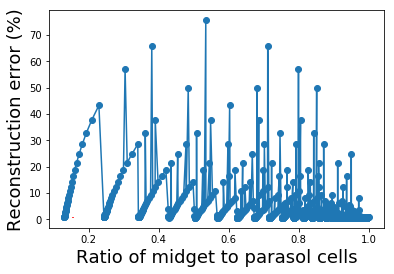

In [295]:
# For reguraly spaced ratios, compute the optimal reconstruction error

#bins = np.logspace(np.log(np.nanmin(ratios))/np.log(10),np.log(np.nanmax(ratios))/np.log(10),500)
bins = np.linspace(np.nanmin(ratios),np.nanmax(ratios),3000)

kept_ratios = list()
kept_recs = list()

for i in range(len(bins)-1):
    keep = (ratios>=bins[i]) & (ratios<=bins[i+1])
    if np.sum(keep)>0 and not np.isnan(np.nanmin(RECS[keep])):
        kept_recs.append(np.nanmin(RECS[keep]))
        kept_ratios.append(bins[i])
        #print(np.sum(keep), np.log(np.nanmin(RECS[keep])))

        
kept_ratios = np.array(kept_ratios)
kept_recs = np.array(kept_recs)
#boolean = np.array([False,*(np.diff(kept_recs)<0)])
#kept_recs[boolean] = np.nan

fig, ax = plt.subplots(1,1,figsize = (6,4))        
ax.plot(kept_ratios,kept_recs,'-o')
ax.plot([kept_ratios[ind_min],kept_ratios[ind_min]], [0.5,0.8],'--r')
ax.set_xlabel('Ratio of midget to parasol cells', fontsize = 18)
ax.set_ylabel('Reconstruction error (%)', fontsize = 18)
#ax.set_ylim([0.5,0.8])
#ax.set_xlim([0.54,1])

#plt.savefig('ratio_rec.eps',bbox_inches = 'tight', pad_inches = .1)


In [296]:
# Compute enveloppe

plt.clf()
def CalculateEdges(x, y):
    edge_list = [];
    for i in range(len(x)):
        (cur_x, cur_y) = (x[i], y[i])
        beaten_in_x = x>cur_x;
        beaten_in_minus_x = x<cur_x;

        beaten_in_y = y>cur_y;

        if(np.sum(beaten_in_x * beaten_in_y)==0):
            edge_list.append((cur_x, cur_y));
            #print('here!')

        if(np.sum(beaten_in_minus_x * beaten_in_y)==0):
            edge_list.append((cur_x, cur_y));
         #   print('here!')


    edge_list = list(set(edge_list)); #Make all entries unique     
    edge_list.sort();

    return (np.array(edge_list)[:, 0], np.array(edge_list)[:, 1])

#print(edge_list)


x_input = kept_ratios
y_input = -kept_recs


(x_edges, y_edges) = CalculateEdges(x_input,y_input);

env_ratios = x_edges
env_recs = -y_edges

#plt.scatter(x_input,y_input)
#plt.plot(x_edges, -y_edges, '-o')

(0.5, 0.8)

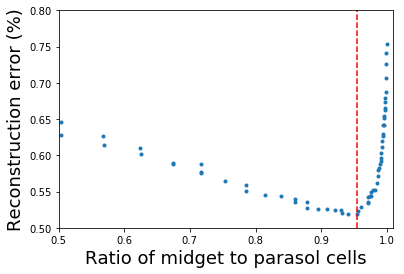

In [300]:

ind_min = np.argmin(env_recs)   

fig, ax = plt.subplots(1,1,figsize = (6,4))        
ax.plot(env_ratios,env_recs,'.')
ax.plot([env_ratios[ind_min],env_ratios[ind_min]], [0.5,0.8],'--r')
ax.set_xlabel('Ratio of midget to parasol cells', fontsize = 18)
ax.set_ylabel('Reconstruction error (%)', fontsize = 18)
ax.set_xlim([0.5,1.01])
ax.set_ylim([0.5,0.8])

#plt.savefig('ratio_rec.eps',bbox_inches = 'tight', pad_inches = .1)

In [68]:
#### RATIO SLIDER AT FIXED VARIANCE EXPLAINED


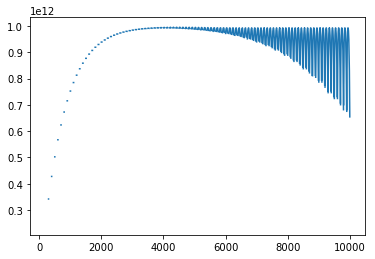

In [69]:
plt.plot(EXPL)

In [70]:

VAREXPL_LIM = 994803764333.0


GRID = np.zeros(NTYPES)
NITER =  stride_grid.shape[1]

EXPL = np.nan* np.zeros(NITER)
OBJ = np.nan*np.zeros(NITER)
L1s = np.nan*np.zeros(NITER)
LAMB = np.nan*np.zeros((NITER,NTYPES))

# start grid search over strides of each type
for i in range(NITER):
    lims = stride_grid[:,i] # end limit of the modes covered by each type

    if np.all(np.diff(lims)>0) and lims[0]>0: # if all limits are in an 
        #increasing order (avoid switching types) 


        lims2 = [0,*lims]

        #print(lims)

        all_varsExpl = list()
        all_l1s = list()
        for typ in range(NTYPES):

            # Variance explained for each lambda
            varExp = cumVarExpl[lims2[typ+1]] - cumVarExpl[lims2[typ]]

            # Budget of cells for each type
            budgetCells = X[lims2[typ+1]] - X[lims2[typ]]

            # penalty
            l1_penalty = np.sqrt(budgetCells*(cumWs[lims2[typ+1]]- cumWs[lims2[typ]]))


            all_varsExpl.append(varExp)
            all_l1s.append(l1_penalty)


        all_varsExpl = np.array(all_varsExpl)
        total_varsExpl = sum([all_varsExpl[ityp,lambda_grid[ityp]] for ityp in range(NTYPES)])

        all_l1s = np.array(all_l1s)
        total_l1s = sum([all_l1s[ityp,lambda_grid[ityp]] for ityp in range(NTYPES)])

        # objective for each lambda
        #objective = total_varsExpl - 1e60 * np.maximum(total_l1s - NSPIKES, 0)  
        objective = -total_l1s - 1e60 * np.maximum(VAREXPL_LIM-total_varsExpl, 0)
        

        best_lambdas_ind = np.argmax(objective)

        best_lambdas = lambda_grid[:,best_lambdas_ind]


        #if 0 in best_lambdas:
        #    print('warning lambda LOWER bound reached',lims)
        #if NLAMBDAS-1 in best_lambdas:
        #    print('warning lambda UPPER bound reached')

        best_objective = objective[best_lambdas_ind]

        best_varExp = total_varsExpl[best_lambdas_ind]
        
        best_L1 = total_l1s[best_lambdas_ind]

        EXPL[i] = best_varExp
        LAMB[i,:] = best_lambdas        
        OBJ[i] = best_objective
        L1s[i] = best_L1 

        #print(best_objective)
        #print(best_varExp)

        #STRIDES[i,:] = best_strides

        #print(lims,best_lambdas,best_objective)

        #print(sumObjs.shape,lambda_grid.shape)


iter_max = np.nanargmax(OBJ)

rec = (np.sum(S) - EXPL[iter_max])/np.sum(S)*100
st = stride_grid[:,iter_max]

recs.append(rec)
strides.append(st)
#print(np.argmax(EXPL))
print('RECONSTRUCTION ERROR: ',rec,'%')
print('BEST NCELLS:', stride_grid[:,iter_max])
print('BEST LAMBDAS:', LAMB[iter_max])
print('OBJ:', OBJ[iter_max])
print('')

RECS = (np.sum(S) - EXPL)/np.sum(S)*100

RECONSTRUCTION ERROR:  0.515868732411 %
BEST NCELLS: [26 45]
BEST LAMBDAS: [ 71.  81.]
OBJ: -1.00093433026e-05



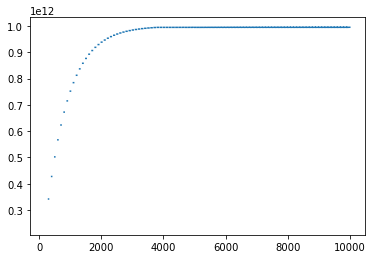

In [71]:
plt.plot(EXPL)

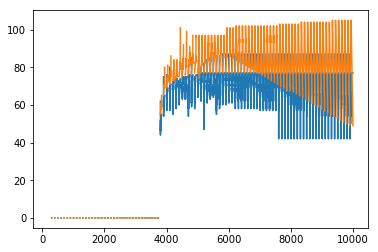

In [72]:
plt.plot(LAMB)

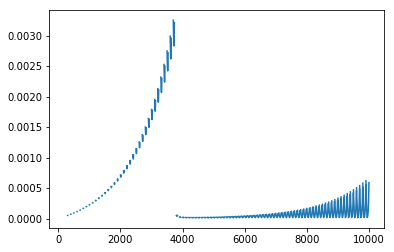

In [73]:
plt.plot(L1s)

/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:236: RuntimeWarning: All-NaN axis encountered
  warnings.warn("All-NaN axis encountered", RuntimeWarning)


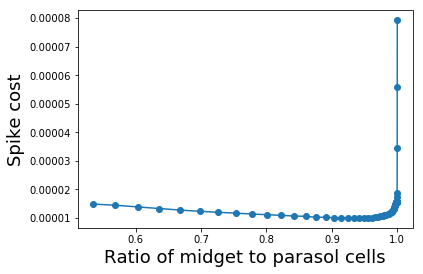

In [76]:
# For reguraly spaced ratios, compute the optimal reconstruction error

bins = np.logspace(np.log(np.min(ratios))/np.log(10),np.log(np.max(ratios))/np.log(10),200000)
#bins = np.linspace(np.min(ratios),np.max(ratios),50)

kept_ratios = list()
kept_l1s = list()

for i in range(len(bins)-1):
    keep = (ratios>=bins[i]) & (ratios<=bins[i+1])
    if np.sum(keep)>0 and not np.isnan(np.nanmin(L1s[keep])):
        kept_l1s.append(np.nanmin(L1s[keep]))
        kept_ratios.append(bins[i])
        #print(np.sum(keep), np.log(np.nanmin(RECS[keep])))

ind_min = np.argmin(kept_l1s)        

fig, ax = plt.subplots(1,1,figsize = (6,4))        
ax.plot(kept_ratios,kept_l1s,'-o')
#ax.plot([kept_ratios[ind_min],kept_ratios[ind_min]], [0.5,0.8],'--r')
ax.set_xlabel('Ratio of midget to parasol cells', fontsize = 18)
ax.set_ylabel('Spike cost', fontsize = 18)
#ax.set_ylim([0.5,0.8])
#ax.set_xlim([0.54,1])

plt.savefig('ratio_l1s.eps',bbox_inches = 'tight', pad_inches = .1)


In [77]:
np.nanmax(L1s)

0.0032522165043758931

In [111]:
np.nanmin(RECS[0])

/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:236: RuntimeWarning: All-NaN axis encountered
  warnings.warn("All-NaN axis encountered", RuntimeWarning)


nan

In [80]:
np.log(np.nanmin(RECS[keep]))

-2.6532335605492792

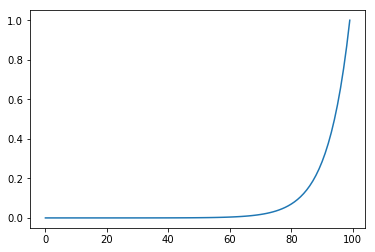

In [76]:
plt.plot(bins)

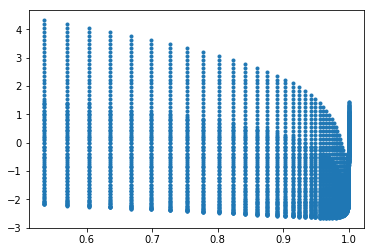

In [57]:
plt.plot(ratio, np.log(RECS),'.')

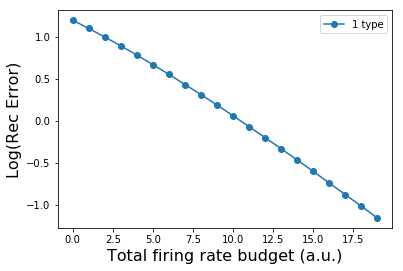

In [20]:
# Reconstruction error wrt spike budgets for different number of types


plt.plot(np.log(np.array(RECS).T)/np.log(10),'-o')
plt.xlabel('Total firing rate budget (a.u.)',fontsize = 16)
plt.ylabel('Log(Rec Error)',fontsize = 16)
#plt.yticks([-1,-2,-3])
plt.legend(['1 type','2 types','3 types'])

#plt.savefig('performance.eps')

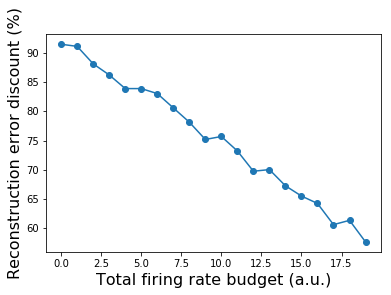

In [9]:
# Ratio of reconstruction error between one type and two types

r = np.array(RECS)
plt.plot(100*r[1]/r[0],'-o')
plt.xlabel('Total firing rate budget (a.u.)',fontsize = 16)
plt.ylabel('Reconstruction error discount (%)',fontsize = 16)
#plt.legend(['1 type','2 types','3 types'])

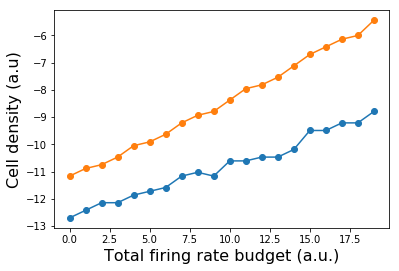

In [10]:
# plot evolution of density with budget

plt.plot(np.log(X[np.array(STRS[1])]),'-o')
#plt.plot(1/np.array(STRS[2]),'-o')
plt.ylabel('Cell density (a.u)',fontsize = 16)
plt.xlabel('Total firing rate budget (a.u.)',fontsize = 16)


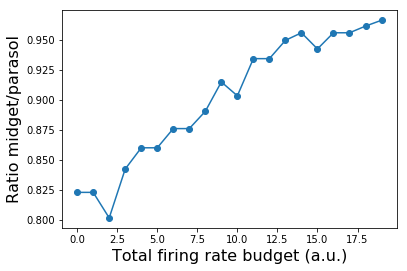

In [11]:
plt.plot(X[np.array(STRS[1])][:,1]/(X[np.array(STRS[1])][:,0]+X[np.array(STRS[1])][:,1]),'-o')
plt.ylabel('Ratio midget/parasol',fontsize = 16)
plt.xlabel('Total firing rate budget (a.u.)',fontsize = 16)

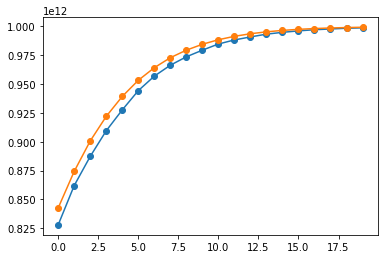

In [12]:
plt.plot(-(np.array(RECS).T/100*np.sum(S)-np.sum(S)),'-o')